In [ ]:
!pip install torch spacy pyttsx3 matplotlib
!python -m spacy download en_core_web_sm

In [2]:
!pip install spacy

  Using cached spacy-3.8.2.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [63 lines of output]
      Ignoring numpy: markers 'python_version < "3.9"' don't match your environment
        Using cached setuptools-80.4.0-py3-none-any.whl.metadata (6.5 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached cymem-2.0.11-cp313-cp313-win_amd64.whl.metadata (8.8 kB)
        Using cached preshed-3.0.9.tar.gz (14 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached murmurhash-1.0.12-cp313-cp313-win_amd64.whl.metadata (2.2 kB)
        Using cached thinc-8.3

In [1]:
# %% [markdown]
# ## 1️⃣ Imports & Setup

# %%
import json
from json import JSONDecodeError
import pickle
import random
import threading
import re
import webbrowser
from collections import deque
from datetime import datetime
import os

import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


ModuleNotFoundError: No module named 'spacy'

In [2]:
import spacy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# Text-to-speech (optional)
try:
    import pyttsx3
    tts_available = True
except:
    tts_available = False

# Check if we're in Colab
IN_COLAB = 'google.colab' in str(get_ipython())

In [4]:
# Set up NLP
nlp = spacy.load("en_core_web_sm")

# Chatbot Model
class ChatbotModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ChatbotModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

# Dataset class
class ChatDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n_samples = len(X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.n_samples


In [5]:
# Cell 3: Trainer Class

class ChatbotTrainer:
    def __init__(self):
        self.all_words = []
        self.tags = []
        self.xy = []
        self.model = None
        self.criterion = None
        self.optimizer = None
        self.history = {'loss': [], 'accuracy': []}

    def prepare_data(self, intents):
        self.tags.clear()
        self.all_words.clear()
        self.xy.clear()
        for intent in intents['intents']:
            tag = intent['tag']
            self.tags.append(tag)
            for pattern in intent['patterns']:
                doc = nlp(pattern)
                words = [tok.text.lower() for tok in doc if not tok.is_punct]
                self.all_words.extend(words)
                self.xy.append((words, tag))
        self.all_words = sorted(set(self.all_words))
        self.tags = sorted(set(self.tags))

    def bag_of_words(self, sentence):
        tokens = [tok.text.lower() for tok in nlp(sentence) if not tok.is_punct]
        bag = [1 if w in tokens else 0 for w in self.all_words]
        return torch.tensor(bag, dtype=torch.float32)

    def train_model(self, intents, epochs=1000, learning_rate=1e-3,
                    hidden_size=8, batch_size=8):
        # Prepare
        self.prepare_data(intents)
        X = []
        y = []
        for words, tag in self.xy:
            X.append(self.bag_of_words(" ".join(words)))
            y.append(self.tags.index(tag))
        X = torch.stack(X)
        y = torch.tensor(y, dtype=torch.long)

        # DataLoader
        dataset = ChatDataset(X, y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Model & optimiser
        self.model = ChatbotModel(len(self.all_words), hidden_size, len(self.tags))
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.history = {'loss': [], 'accuracy': []}

        for epoch in range(1, epochs+1):
            for batch_X, batch_y in loader:
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # log every 100
            if epoch % 100 == 0:
                with torch.no_grad():
                    all_out = self.model(X)
                    preds = torch.argmax(all_out, dim=1)
                    acc = (preds == y).float().mean().item()
                self.history['loss'].append(loss.item())
                self.history['accuracy'].append(acc)
                if IN_COLAB:
                    from IPython.display import clear_output
                    clear_output(wait=True)
                    plt.figure(figsize=(10,4))
                    plt.subplot(1,2,1)
                    plt.plot(self.history['loss'])
                    plt.title("Loss")
                    plt.subplot(1,2,2)
                    plt.plot(self.history['accuracy'])
                    plt.title("Accuracy")
                    plt.show()
                    print(f"Epoch {epoch}/{epochs}  Loss: {loss:.4f}  Acc: {acc:.2f}")

        return self.model, self.history

    def predict(self, sentence, intents):
        bag = self.bag_of_words(sentence)
        with torch.no_grad():
            out = self.model(bag)
            tag_idx = torch.argmax(out).item()
        tag = self.tags[tag_idx]
        for intent in intents['intents']:
            if intent['tag'] == tag:
                return random.choice(intent['responses'])
        return "I'm not sure how to respond to that."


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


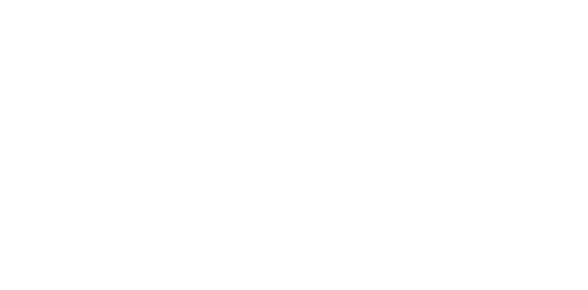

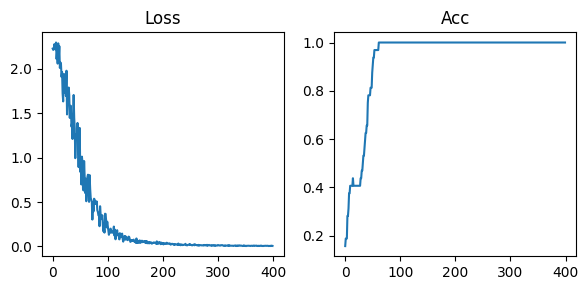

Epoch 800/1500 — loss 0.0009, acc 1.00


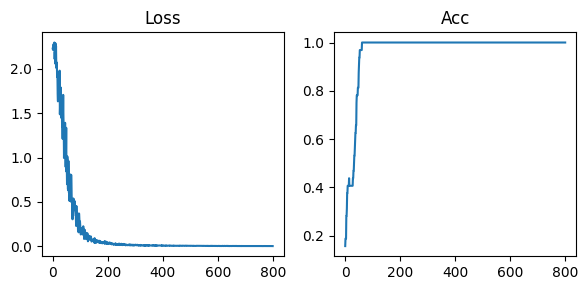

Epoch 1400/1500 — loss 0.0002, acc 1.00


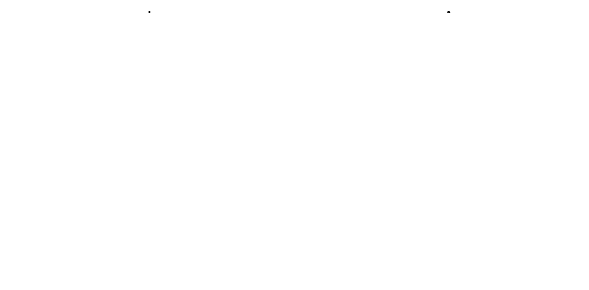

Epoch 1500/1500 — loss 0.0002, acc 1.00


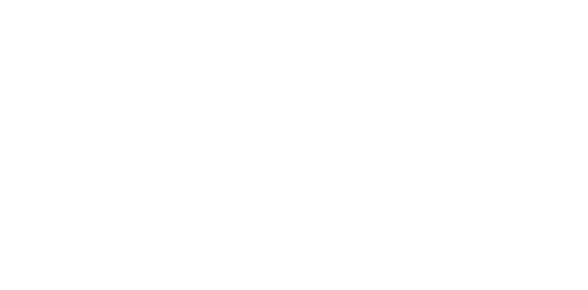

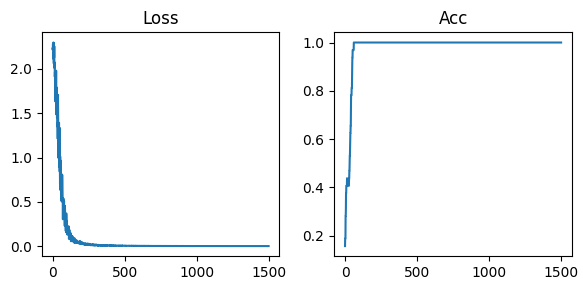

In [ ]:
# 1️⃣ Mount Google Drive (Colab only)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# 2️⃣ Imports & Constants
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
from ipywidgets import Layout


# TTS support
try:
    import pyttsx3
    tts_available = True
except ImportError:
    tts_available = False

IN_COLAB = 'google.colab' in str(get_ipython())
INTENTS_PATH = "C:\Users\A S U S\Desktop\Project submitted by Nabin Nepali\project_intents.json"

# 3️⃣ Load spaCy model
nlp = spacy.load("en_core_web_sm")

# 4️⃣ Dataset & Model Definitions
class ChatDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ChatbotModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# 5️⃣ Enhanced Trainer
class ChatbotTrainer:
    def __init__(self):
        self.all_words = []
        self.tags = []
        self.xy = []
        self.model = None
        self.history = {'loss': [], 'accuracy': []}

    def prepare_data(self, intents):
        self.all_words.clear()
        self.tags.clear()
        self.xy.clear()
        for intent in intents['intents']:
            tag = intent['tag']
            self.tags.append(tag)
            for pat in intent['patterns']:
                tokens = [tok.text.lower() for tok in nlp(pat) if not tok.is_punct]
                self.all_words.extend(tokens)
                self.xy.append((tokens, tag))
        self.all_words = sorted(set(self.all_words))
        self.tags = sorted(set(self.tags))

    def bag_of_words(self, sentence):
        tokens = [tok.text.lower() for tok in nlp(sentence) if not tok.is_punct]
        return torch.tensor([1 if w in tokens else 0 for w in self.all_words],
                             dtype=torch.float32)

    def train_model(self, intents, epochs=1000, learning_rate=1e-3,
                    hidden_size=8, batch_size=8, progress_callback=None):
        self.prepare_data(intents)
        X = torch.stack([self.bag_of_words(" ".join(ws)) for ws, _ in self.xy])
        y = torch.tensor([self.tags.index(tag) for _, tag in self.xy], dtype=torch.long)

        loader = DataLoader(ChatDataset(X, y), batch_size=batch_size, shuffle=True)
        self.model = ChatbotModel(len(self.all_words), hidden_size, len(self.tags))
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.history = {'loss': [], 'accuracy': []}

        for epoch in range(1, epochs+1):
            for bx, by in loader:
                out = self.model(bx)
                loss = criterion(out, by)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                all_out = self.model(X)
                preds = torch.argmax(all_out, dim=1)
                acc = (preds == y).float().mean().item()
            self.history['loss'].append(loss.item())
            self.history['accuracy'].append(acc)

            if progress_callback and epoch % 100 == 0:
                progress_callback(epoch, loss.item(), acc)

        return self.model

    def predict(self, sentence, intents):
        bow = self.bag_of_words(sentence)
        with torch.no_grad():
            out = self.model(bow)
            tag = self.tags[torch.argmax(out).item()]
        for intent in intents['intents']:
            if intent['tag'] == tag:
                return random.choice(intent['responses'])
        return "I'm not sure how to respond to that."

# 6️⃣ Enhanced GUI with Name Prompt and Scrollable Chat
class ChatbotGUI:
    def __init__(self):
        self.trainer = ChatbotTrainer()
        self.tts_engine = None
        self.tts_enabled = False
        self.dark_mode = False
        self.chat_history = []
        self.memory_buffer = deque(maxlen=5)
        self.bot_name = "ChatBot"  # Default name

        # Initialize TTS if available
        if tts_available:
            try:
                self.tts_engine = pyttsx3.init()
                self.tts_engine.setProperty('rate', 150)
            except:
                self.tts_engine = None

        # First show name prompt
        self._show_name_prompt()

    def _show_name_prompt(self):
        """Display initial name prompt before showing main interface"""
        self.name_input = widgets.Text(
            value='',
            placeholder='Enter your chatbot name',
            description='Name:',
            disabled=False
        )
        self.name_submit = widgets.Button(description='Submit')
        self.name_submit.on_click(self._handle_name_submit)

        self.name_prompt = widgets.VBox([
            widgets.HTML("<h2>Welcome to ChatBot Setup</h2>"),
            widgets.HTML("<p>Please give your chatbot a name:</p>"),
            widgets.HBox([self.name_input, self.name_submit])
        ])

        display(self.name_prompt)

    def _handle_name_submit(self, _):
        """Process the submitted bot name"""
        name = self.name_input.value.strip()
        if name:
            self.bot_name = name
            self.name_prompt.close()
            self._build_widgets()
            self._load_intents_from_drive()
            with self.chat_out:
                print(f"{self.bot_name}: Hello! How can I help you today?")

    def _load_intents_from_drive(self):
        if os.path.isfile(INTENTS_PATH):
            try:
                with open(INTENTS_PATH, 'r') as f:
                    self.intents = json.load(f)
            except (JSONDecodeError, ValueError):
                self._write_default_intents()
        else:
            self._write_default_intents()
        self._update_intents_display()

    def _write_default_intents(self):
        self.intents = {
            "intents": [
                {"tag": "greeting", "patterns": ["Hi","Hello","Hey"], "responses": ["Hello!","Hi there!"]},
                {"tag": "goodbye",  "patterns": ["Bye","See you"],    "responses": ["Goodbye!","See you later!"]},
                {"tag": "thanks",   "patterns": ["Thanks","Thank you"],"responses": ["You're welcome!"]},
                {"tag": "name",     "patterns": ["What's your name?","Who are you?"],
                 "responses": [f"I'm {self.bot_name}, your personal assistant!", f"You can call me {self.bot_name}"]}
            ]
        }
        os.makedirs(os.path.dirname(INTENTS_PATH), exist_ok=True)
        self._save_intents()

    def _save_intents(self):
        with open(INTENTS_PATH, 'w') as f:
            json.dump(self.intents, f, indent=2)

    def _build_widgets(self):
        # Training controls
        self.epochs_slider = widgets.IntSlider(value=1000, min=100, max=5000, step=100, description='Epochs')
        self.lr_slider = widgets.FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4, description='LR')
        self.train_btn = widgets.Button(description='Train')
        self.train_btn.on_click(self._on_train)

        self.train_out = widgets.Output(layout={'border':'1px solid gray','height':'300px'})
        train_box = widgets.VBox([
            widgets.HBox([self.epochs_slider, self.lr_slider, self.train_btn]),
            self.train_out
        ])

        # Intent editor
        self.tag_in = widgets.Text(description='Tag')
        self.pat_in = widgets.Text(description='Pattern')
        self.res_in = widgets.Text(description='Response')
        self.add_btn = widgets.Button(description='Add Intent')
        self.add_btn.on_click(self._on_add_intent)
        self.int_area = widgets.Textarea(disabled=True, layout={'width':'100%','height':'200px'})
        intent_box = widgets.VBox([
            widgets.HBox([self.tag_in, self.pat_in, self.res_in, self.add_btn]),
            self.int_area
        ])

        # Enhanced Chat pane with scrolling
        self.chat_out = widgets.Output(
            layout=Layout(
                border='1px solid black',
                height='300px',
                width='100%',
                overflow_y='auto',
                overflow_x='hidden'
            )
        )

        # Make chat output scroll to bottom automatically
        def scroll_to_bottom():
            self.chat_out._scroll_to_bottom()

        self.user_in = widgets.Text(layout={'width':'80%'})
        self.send_btn = widgets.Button(description='Send')
        self.send_btn.on_click(self._on_send)

        # Extras
        self.tts_toggle = widgets.ToggleButton(False, description='TTS')
        self.tts_toggle.observe(self._on_tts_toggle, 'value')
        self.export_btn = widgets.Button(description='Export')
        self.export_btn.on_click(self._on_export)
        self.theme_btn = widgets.Button(description='Theme')
        self.theme_btn.on_click(self._on_theme)

        extras_box = widgets.HBox([self.tts_toggle, self.export_btn, self.theme_btn])
        chat_box = widgets.VBox([
            self.chat_out,
            widgets.HBox([self.user_in, self.send_btn]),
            extras_box
        ])

        display(widgets.VBox([train_box, intent_box, chat_box]))

    def _update_intents_display(self):
        self.int_area.value = json.dumps(self.intents, indent=2)

    def _on_add_intent(self, _):
        tag, pat, res = self.tag_in.value.strip(), self.pat_in.value.strip(), self.res_in.value.strip()
        if not (tag and pat and res):
            with self.chat_out:
                print("Please fill all fields.")
            return

        for intent in self.intents['intents']:
            if intent['tag'] == tag:
                intent['patterns'].append(pat)
                intent['responses'].append(res)
                break
        else:
            self.intents['intents'].append({'tag':tag,'patterns':[pat],'responses':[res]})

        self._save_intents()
        self._update_intents_display()
        self.tag_in.value = self.pat_in.value = self.res_in.value = ''
        with self.chat_out:
            print(f"Saved intent '{tag}'")

    def _on_train(self, _):
        def _train():
            epochs = self.epochs_slider.value
            lr = self.lr_slider.value

            def progress_cb(ep, loss, acc):
                with self.train_out:
                    clear_output(wait=True)
                    print(f"Epoch {ep}/{epochs} — loss {loss:.4f}, acc {acc:.2f}")
                    plt.figure(figsize=(6,3))
                    plt.subplot(1,2,1); plt.plot(self.trainer.history['loss']); plt.title("Loss")
                    plt.subplot(1,2,2); plt.plot(self.trainer.history['accuracy']); plt.title("Acc")
                    plt.tight_layout()
                    plt.show()

            with self.train_out:
                clear_output(wait=True)
                print(f"➡️ Training for {epochs} epochs @ lr={lr} …")

            self.trainer.train_model(
                self.intents,
                epochs=epochs,
                learning_rate=lr,
                hidden_size=8,
                batch_size=8,
                progress_callback=progress_cb
            )

            with self.train_out:
                print("✅ Training complete!")

        threading.Thread(target=_train, daemon=True).start()

    def _on_send(self, _):
        msg = self.user_in.value.strip()
        if not msg:
            return

        self.user_in.value = ''

        # Add user message to history
        self.chat_history.append(f"You: {msg}")

        # Get and add bot response
        if not self.trainer.model:
            response = "Please train me first!"
        else:
            response = self.trainer.predict(msg, self.intents)

        self.chat_history.append(f"{self.bot_name}: {response}")

        # Update chat display with proper formatting
        with self.chat_out:
            clear_output(wait=True)
            for line in self.chat_history[-100:]:  # Show last 100 messages
                # Format different speaker messages differently
                if line.startswith("You:"):
                    display(HTML(f"<div style='color:yellow; margin: 5px 0;'>{line}</div>"))
                else:
                    display(HTML(f"<div style='color:#39FF14; margin: 5px 0;'>{line}</div>"))

        # Text-to-speech
        if self.tts_enabled and self.tts_engine:
            self.tts_engine.say(response)
            self.tts_engine.runAndWait()

    def _on_tts_toggle(self, change):
        self.tts_enabled = change['new']
        with self.chat_out:
            print("TTS", "enabled" if self.tts_enabled else "disabled")

    def _on_export(self, _):
        fn = f"chat_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
        with open(fn, 'w') as f:
            f.write(f"Chat with {self.bot_name}\n\n")
            for msg in self.chat_history:
                f.write(msg + '\n')
        with self.chat_out:
            print(f"Exported chat log to {fn}")

    def _on_theme(self, _):
        self.dark_mode = not self.dark_mode
        plt.style.use('dark_background' if self.dark_mode else 'default')
        with self.chat_out:
            print("Theme switched to", "dark" if self.dark_mode else "light")

# 7️⃣ Instantiate the GUI
if IN_COLAB:
    chatbot = ChatbotGUI()